In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

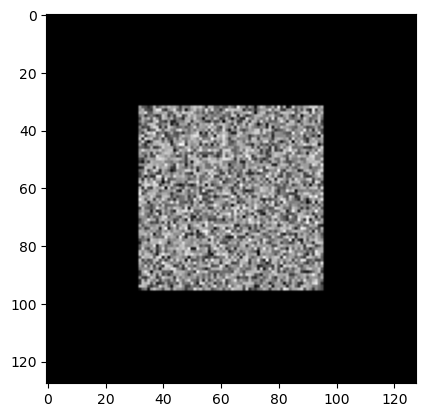

In [3]:
test_im = torch.rand(1,64, 64, dtype = torch.cfloat)
#Pad all sides of test_im with 32 pixels
test_im = F.pad(test_im, (32,32,32,32))

#Plot test_im image
plt.imshow(abs(test_im.squeeze()), cmap='gray')

/home/beams/AVONG/miniconda3/envs/ptychopinn_pytorch/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538455419/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/beams/AVONG/miniconda3/envs/ptychopinn_pytorch/lib/python3.12/site-packages/torch/nn/functional.py:4373: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


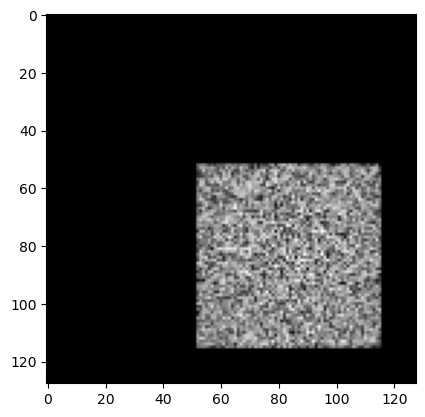

In [4]:
c, h, w = test_im.shape
mu_x, mu_y = (20, 20)
x_s, y_s = (torch.arange(h) - mu_y)/(h-1), (torch.arange(w) - mu_x)/(w-1)

grid_shifted = torch.dstack(torch.meshgrid(x_s,y_s)) * 2 - 1 #Convert to -1 to 1 range

#Must sample real and imag part separately
sampled_real = F.grid_sample(test_im.real[None], grid_shifted[None])
sampled_imag = F.grid_sample(test_im.imag[None], grid_shifted[None])

#Combine sampled into one tensor
sampled_im = torch.view_as_complex(torch.stack((sampled_real,sampled_imag),-1))

plt.imshow(abs(sampled_im.squeeze()), cmap='gray')

In [19]:
sampled_im.shape

torch.Size([1, 1, 128, 128])

In [18]:
torch.count_nonzero(sampled_im, dim = 3)

tensor([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
          64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0]]])

Testing creating a batched meshgrid used in the translation helper function

In [30]:
x = torch.arange(h)/(h-1)
y = torch.arange(w)/(w-1)
#Create randomized offset tensor
offset = torch.rand(4, 1, 2) * 5

offset_x = offset[:,:,0]
offset_y = offset[:,:,1]

#Add x and offset_x
x_shifted = x + offset_x
y_shifted = y + offset_y

#Make grid based on stackeoverflow 72782751
#x_shifted.unsqueeze(-1) -> (4, 128) to (4, 128, 1)
#expand -> (4,128,1) to (4, 128, 128)
grid = torch.stack([x_shifted.unsqueeze(-1).expand(4, -1, y_shifted.shape[1]),
                    y_shifted.unsqueeze(1).expand(4, x_shifted.shape[1], -1)],
                    dim = -1)



In [36]:
test_im.unsqueeze(1).shape

torch.Size([1, 1, 128, 128])

In [34]:
print(x_shifted[0,:10])
print(x_shifted[3,:10])

tensor([0.8573, 0.8652, 0.8731, 0.8809, 0.8888, 0.8967, 0.9046, 0.9124, 0.9203,
        0.9282])
tensor([1.4328, 1.4406, 1.4485, 1.4564, 1.4643, 1.4721, 1.4800, 1.4879, 1.4958,
        1.5036])


In [31]:
x_shifted.unsqueeze(-1).expand(4, -1, y_shifted.shape[1]).shape

torch.Size([4, 128, 128])